In [1]:
import numpy as np
import matplotlib.pyplot as plt                    #LIBRERIAS NECESARIAS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0) #Con estea semilla podemos volver a generar de la misma forma los datos.

# Señal con ruido

$Y = Cos(\frac{24\pi}{3}) + Cos(\frac{24\pi}{4})$

$\hat{Y} = Y + \eta$

$\eta = N(0,\sigma^2)$

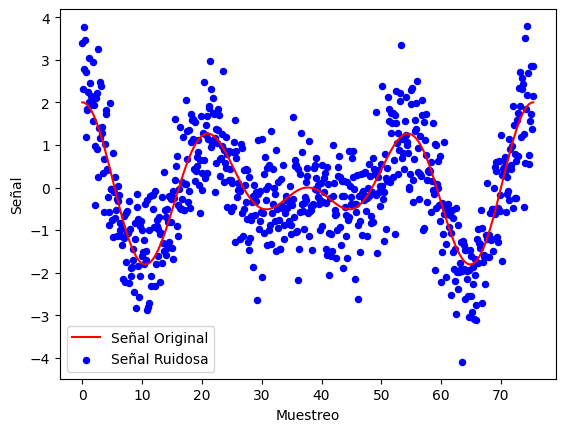

In [2]:
def var_snr(x,snrdB): #Función que entrega la varianza del ruido tomando en cuenta su potencia en dB
    Px = np.mean(x**2)
    return Px/(10**(snrdB/10))

snrdB = 2
N = 700 #Muestras 500 de entrenamiento + 200 de testeo

X = np.linspace(0, 24*np.pi, N)  #array de tiempo
Y_true = np.cos(X/3)+np.cos(X/4)  #señal limpia de cosenos

var_noise = var_snr(Y_true, snrdB) #Hallar varianza del ruido

Y = Y_true + np.random.normal(0, np.sqrt(var_noise), len(X)) #Señal contaminada con ruido gaussiano media 0, varianza var_noise

X = X.reshape(-1,1) #Sklearn sólo entiendo en vectores columna, por esto mismo transformamos los datos de fila a columna
Y = Y.reshape(-1,1)

Y_true_upper = Y_true + np.sqrt(var_noise)  #Para pintar región de incertidumbre, límites de región de incertidumbre
Y_true_lower = Y_true - np.sqrt(var_noise)

plt.plot(X, Y_true, c='r', label='Señal Original')
plt.scatter(X, Y, c='b', s=19, label='Señal Ruidosa')
plt.legend()
plt.xlabel('Muestreo')
plt.ylabel('Señal')
plt.show()

# Preparar los datos

MinMaxScaler() es un normalizador que transforma un vector con unos límites específicos

train_test_split() divide los datos de manera aleatoria según el porcentaje que uno desee

In [3]:
scaler_X = MinMaxScaler() #Creamos2 dos variables que contienen los modelos de normalización
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X) #Normalizamos los valores en un rango de [0,1]
Y_scaled = scaler_Y.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=200/N, random_state=42) #Dividimos nuestros datos 500 train 200 test
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Q = 29 #grado de la matriz Phi
phiQ = PolynomialFeatures(degree=Q) #Generar matriz Phi

(500, 1) (200, 1) (500, 1) (200, 1)


## Maxima Verosimilitud

$\hat{\theta} = (\Phi^T\Phi)^{-1} \Phi^T y$

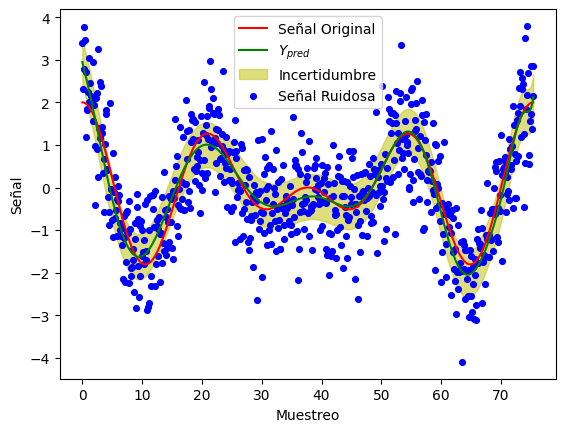

In [4]:

def max_ver(X_train, Y_train, phiQ):
    Phi_train = phiQ.fit_transform(X_train)  # Aplicar la transformación polinomial a los datos X

    return np.linalg.pinv(Phi_train.T @ Phi_train) @ Phi_train.T @ Y_train #aplicamos fórmula

X_range = np.linspace(0, 1, 1000).reshape(-1,1) #vector de ayuda para graficar
Phi_test = phiQ.fit_transform(X_range)
theta = max_ver(X_train, Y_train, phiQ) #hallamos theta

Y_pred = Phi_test @ theta #configuramos datos de predicción


sigma = np.sqrt(np.sum((Y - phiQ.fit_transform(X_scaled) @ theta)**2) / (len(Y) - Q - 1)) * 0.5  # Reducción del tamaño de sigma
Y_pred_upper = Y_pred + .1 * sigma  # Intervalo de confianza reducido
Y_pred_lower = Y_pred - .1 * sigma

plt.plot(X, Y_true, c='r', label='Señal Original')
plt.plot(scaler_X.inverse_transform(X_range), scaler_Y.inverse_transform(Y_pred), c='g', label='$Y_{pred}$')
plt.fill_between(scaler_X.inverse_transform(X_range).flatten(), scaler_Y.inverse_transform(Y_pred_lower).flatten(), scaler_Y.inverse_transform(Y_pred_upper).flatten(), color='y', alpha=0.5, label='Incertidumbre')

plt.scatter(X, Y, c='b', s=17, label='Señal Ruidosa')
plt.legend()
plt.xlabel('Muestreo')
plt.ylabel('Señal')
plt.show()

## Maximo a Posteriori

$W_{map} = (\Phi^T\Phi + \lambda I)^{-1} \Phi^T y$

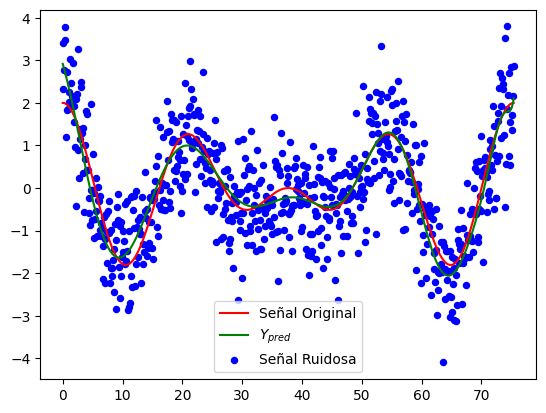

In [5]:
def MAP(X_train, Y_train, alpha, phiQ):
    Phi_train = phiQ.fit_transform(X_train)
    I = np.eye(Phi_train.shape[1]) #matriz identidad

    return np.linalg.pinv((Phi_train.T @ Phi_train) + (alpha * I)) @ Phi_train.T @ Y_train #Fórmula

X_range = np.linspace(0, 1, 1000).reshape(-1,1) #vector de ayuda para graficar
w = MAP(X_train, Y_train, 1e-13, phiQ)
Phi_test = phiQ.fit_transform(X_range)

Y_pred = Phi_test @ w #predecimos

plt.plot(X, Y_true, c='r', label='Señal Original')
plt.plot(scaler_X.inverse_transform(X_range), scaler_Y.inverse_transform(Y_pred), c='g', label='$Y_{pred}$')
plt.scatter(X, Y, c='b', s=19, label='Señal Ruidosa')
plt.legend()
plt.show()

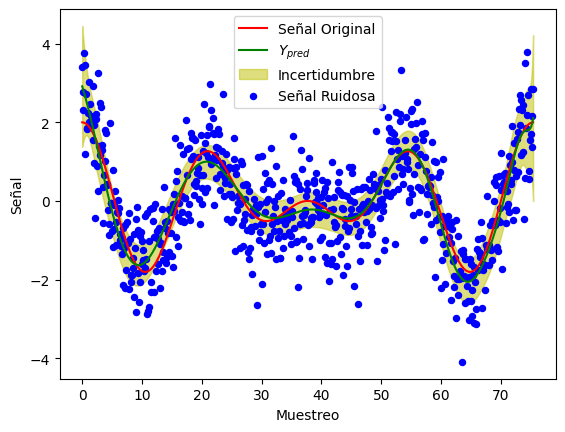

In [6]:
# Cálculo de la incertidumbre (varianza de la predicción)
sigma_noise = np.sqrt(var_noise)  # Desviación estándar del ruido
phiQ_X_train = phiQ.fit_transform(X_train)
cov_matrix = np.linalg.pinv(phiQ_X_train.T @ phiQ_X_train + 1e-13 * np.eye(phiQ_X_train.shape[1]))
sigma_pred = np.sqrt(np.sum(Phi_test @ cov_matrix * Phi_test, axis=1)) * sigma_noise

Y_pred_upper = Y_pred + 0.5 * sigma_pred.reshape(-1, 1)
Y_pred_lower = Y_pred - 0.5 * sigma_pred.reshape(-1, 1)

plt.plot(X, Y_true, c='r', label='Señal Original')
plt.plot(scaler_X.inverse_transform(X_range), scaler_Y.inverse_transform(Y_pred), c='g', label='$Y_{pred}$')
plt.fill_between(scaler_X.inverse_transform(X_range).flatten(),
                 scaler_Y.inverse_transform(Y_pred_lower).flatten(),
                 scaler_Y.inverse_transform(Y_pred_upper).flatten(),
                 color='y', alpha=0.5, label='Incertidumbre')
plt.scatter(X, Y, c='b', s=19, label='Señal Ruidosa')
plt.legend()
plt.xlabel('Muestreo')
plt.ylabel('Señal')
plt.show()